**Import necessary libraries**

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# **Part 3(EDA)**

**Download and load the dataset**

In [2]:
# https://drive.google.com/file/d/1-0qZIbFEy-0bUP6K0Ai-UVChzMuyA2X9/view?usp=sharing
!pip install gdown
import gdown

file_id = "1-0qZIbFEy-0bUP6K0Ai-UVChzMuyA2X9"
url = f"https://drive.google.com/uc?id={file_id}"
output = "Housing.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-0qZIbFEy-0bUP6K0Ai-UVChzMuyA2X9
To: /content/Housing.csv
100%|██████████| 30.0k/30.0k [00:00<00:00, 20.0MB/s]


'Housing.csv'

In [3]:
df = pd.read_csv("Housing.csv")


In [4]:
# 4. Display the first five rows
print("First five rows of the dataset:")
display(df.head())

First five rows of the dataset:


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [5]:
# 5. Identify numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumber of numerical features: {len(numerical_features)}")
print(f"Numerical columns: {numerical_features}")
print(f"\nNumber of categorical features: {len(categorical_features)}")
print(f"Categorical columns: {categorical_features}")


Number of numerical features: 6
Numerical columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

Number of categorical features: 7
Categorical columns: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


/tmp/ipython-input-3778946695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="coolwarm")
/tmp/ipython-input-3778946695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="coolwarm")
/tmp/ipython-input-3778946695.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="coolwarm")


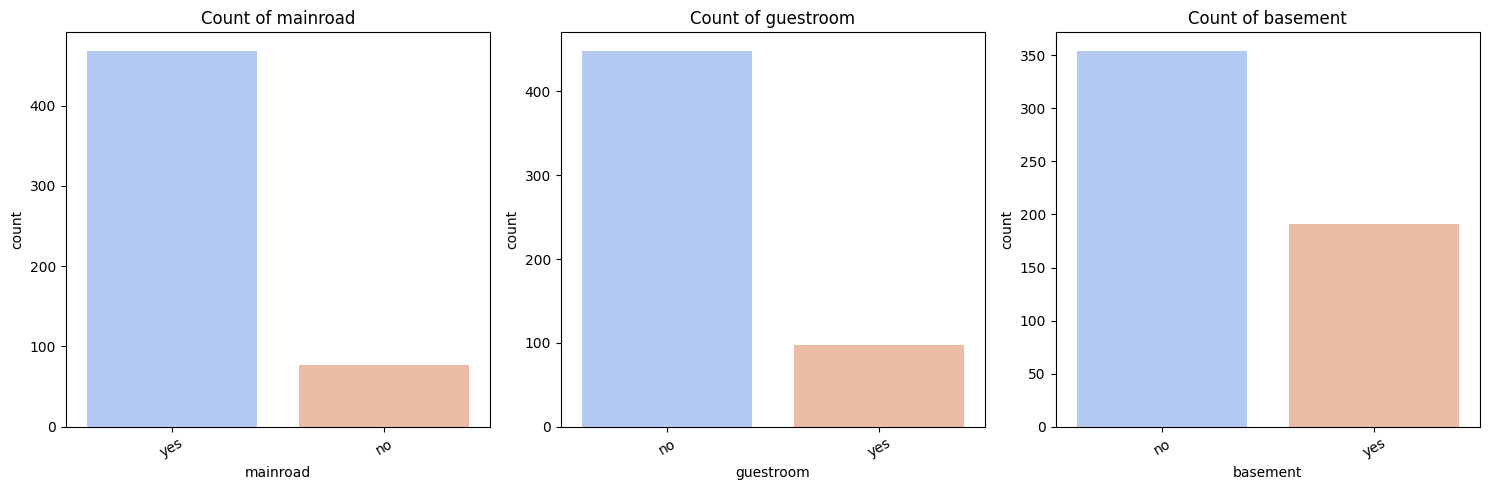

In [6]:
# 6. Visualize selected categorical features
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_features[:3]):  # visualize first 3 categorical features
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=col, data=df, palette="coolwarm")
    plt.title(f"Count of {col}")
    plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

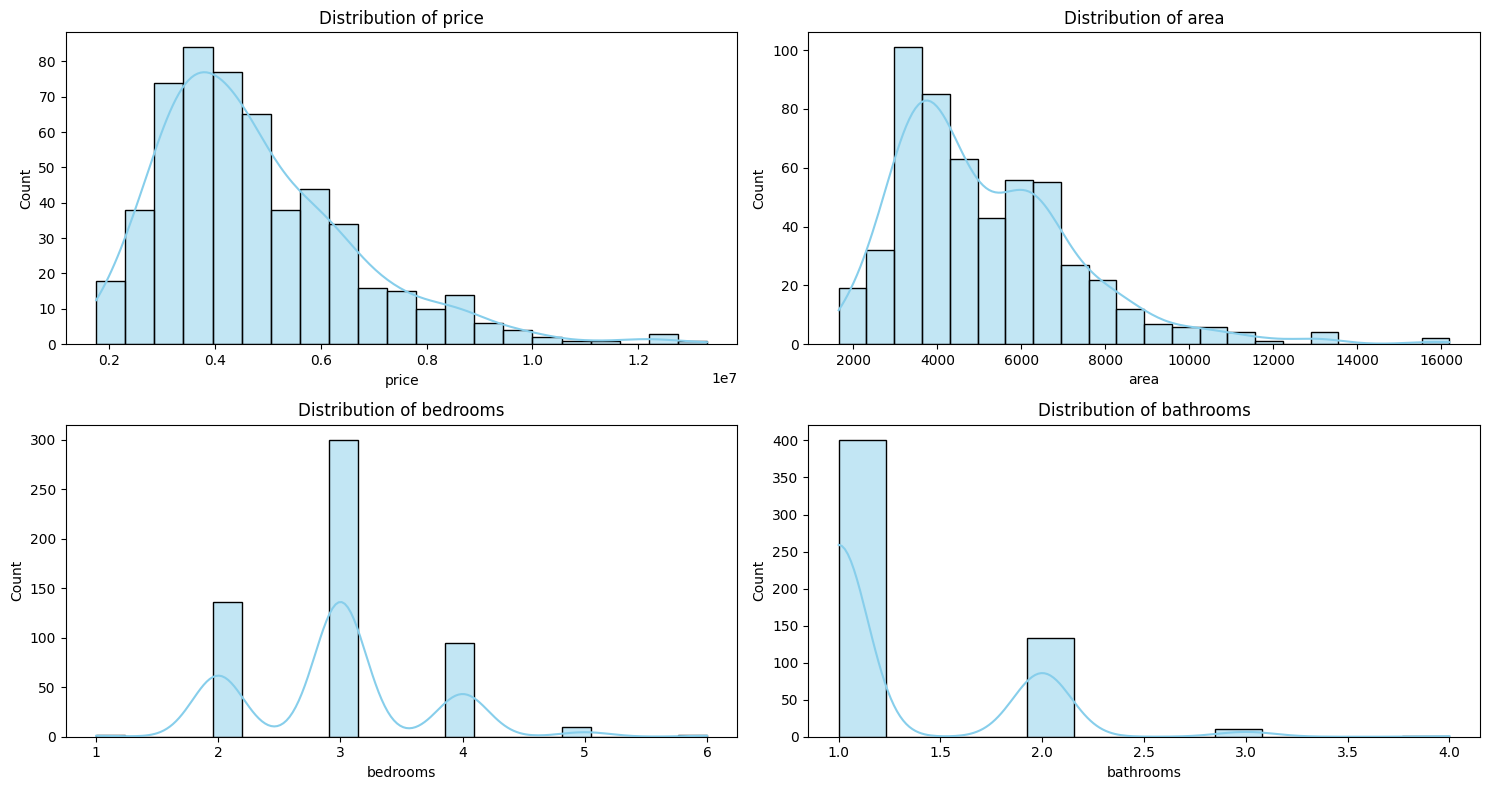

In [7]:
# 7. Plot distributions of numerical features

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_features[:4]):  # visualize first 4 numerical features
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[col], kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

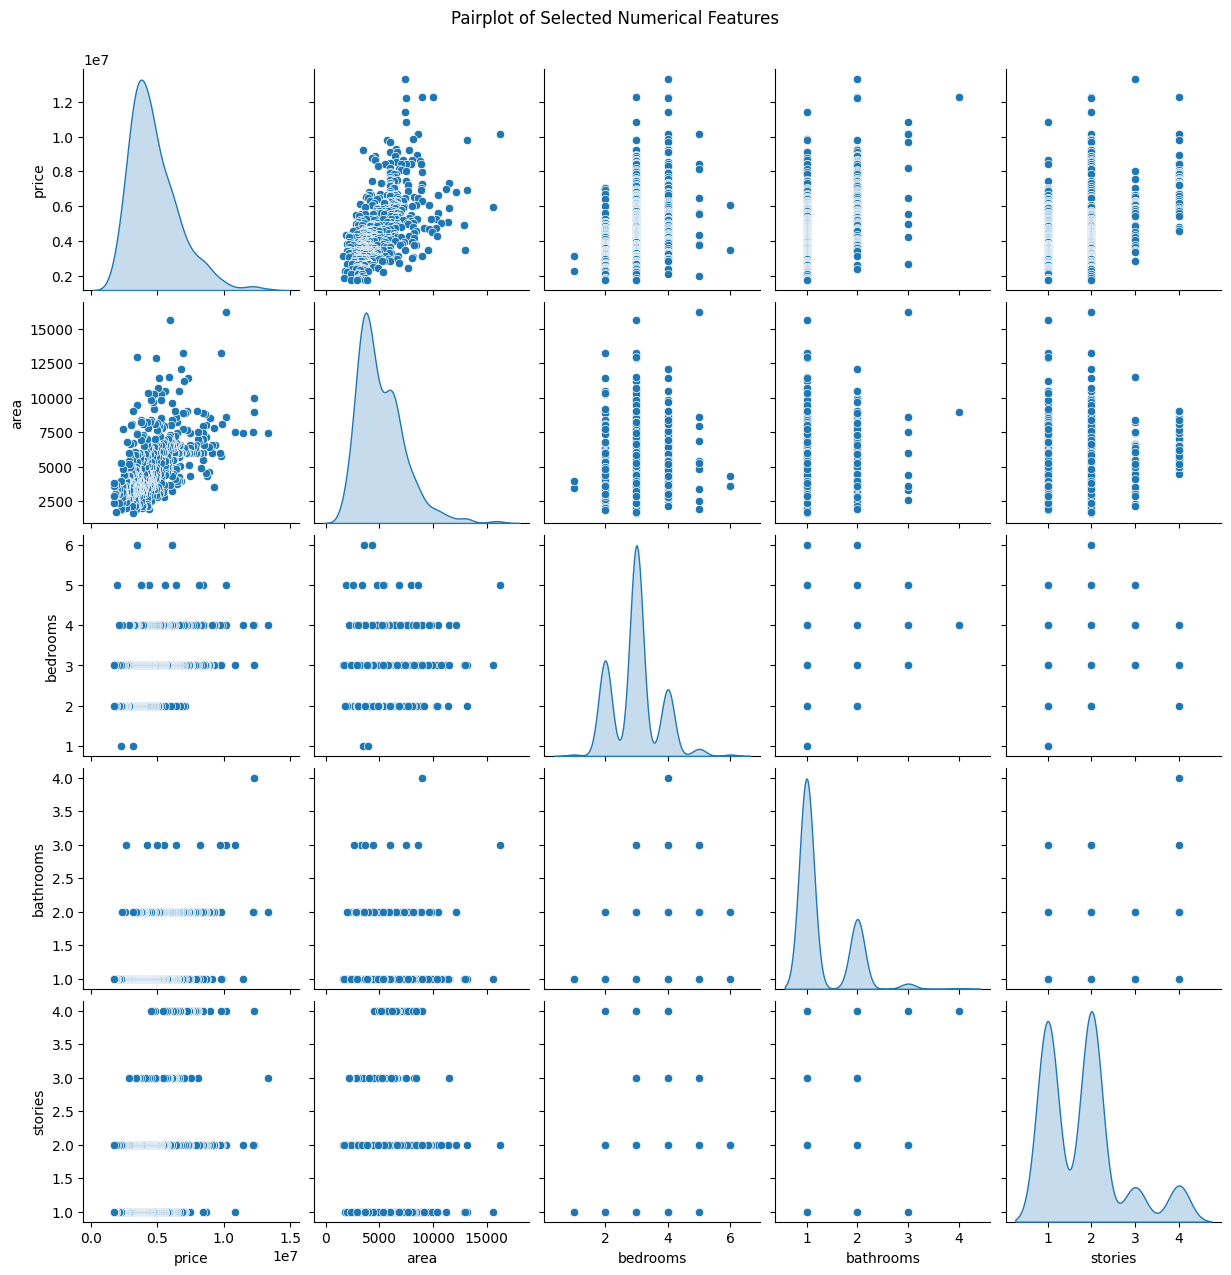

In [8]:
# 8. Pairplot to visualize relationships
selected_features = numerical_features[:5]  # choose first 5 numerical columns for clarity
sns.pairplot(df[selected_features], diag_kind='kde')
plt.suptitle("Pairplot of Selected Numerical Features", y=1.02)
plt.show()

# **Part 4(preprocessing)**

**1. Check for duplicate rows**

In [10]:
print("Number of duplicate rows:", df.duplicated().sum())

# Remove duplicates if any
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

Number of duplicate rows: 0
After removing duplicates: (545, 13)


**2. Check for missing data**

In [11]:
print("\nMissing values per column:")
print(df.isnull().sum())



Missing values per column:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


**Handling missing data**

In [12]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after handling:")
print(df.isnull().sum())


Missing values after handling:
price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


**3. Identify and explain feature types**

In [13]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumerical features:", numerical_features)
print("Categorical features:", categorical_features)



Numerical features: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical features: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


**4. Encode categorical features**

In [14]:
df_encoded = df.copy()
df_encoded = pd.get_dummies(df_encoded, columns=categorical_features, drop_first=True)

print("\nData after encoding:")
display(df_encoded.head())



Data after encoding:


,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,2,True,False,False,False,True,True,False,False
1,12250000,8960,4,4,4,3,True,False,False,False,True,False,False,False
2,12250000,9960,3,2,2,2,True,False,True,False,False,True,True,False
3,12215000,7500,4,2,2,3,True,False,True,False,True,True,False,False
4,11410000,7420,4,1,2,2,True,True,True,False,True,False,False,False


**5. Identify and handle outliers**

In [17]:
for col in numerical_features:
    Q1 = df_encoded[col].quantile(0.25)
    Q3 = df_encoded[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_encoded[col] = np.where(df_encoded[col] < lower, lower, df_encoded[col])
    df_encoded[col] = np.where(df_encoded[col] > upper, upper, df_encoded[col])

print("\nOutliers handled using IQR capping method.")


Outliers handled using IQR capping method.


**6. Split the dataset (80/20)**

In [18]:
target_column = 'price' if 'price' in df_encoded.columns else df_encoded.columns[-1]

X = df_encoded.drop(columns=[target_column])
y = df_encoded[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (436, 13)
Testing set size: (109, 13)


**7. Normalize the data**

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData normalization complete.")


Data normalization complete.


# **Part 5(Feature Selection)**


In [21]:
X_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)


**1. Correlation Matrix**

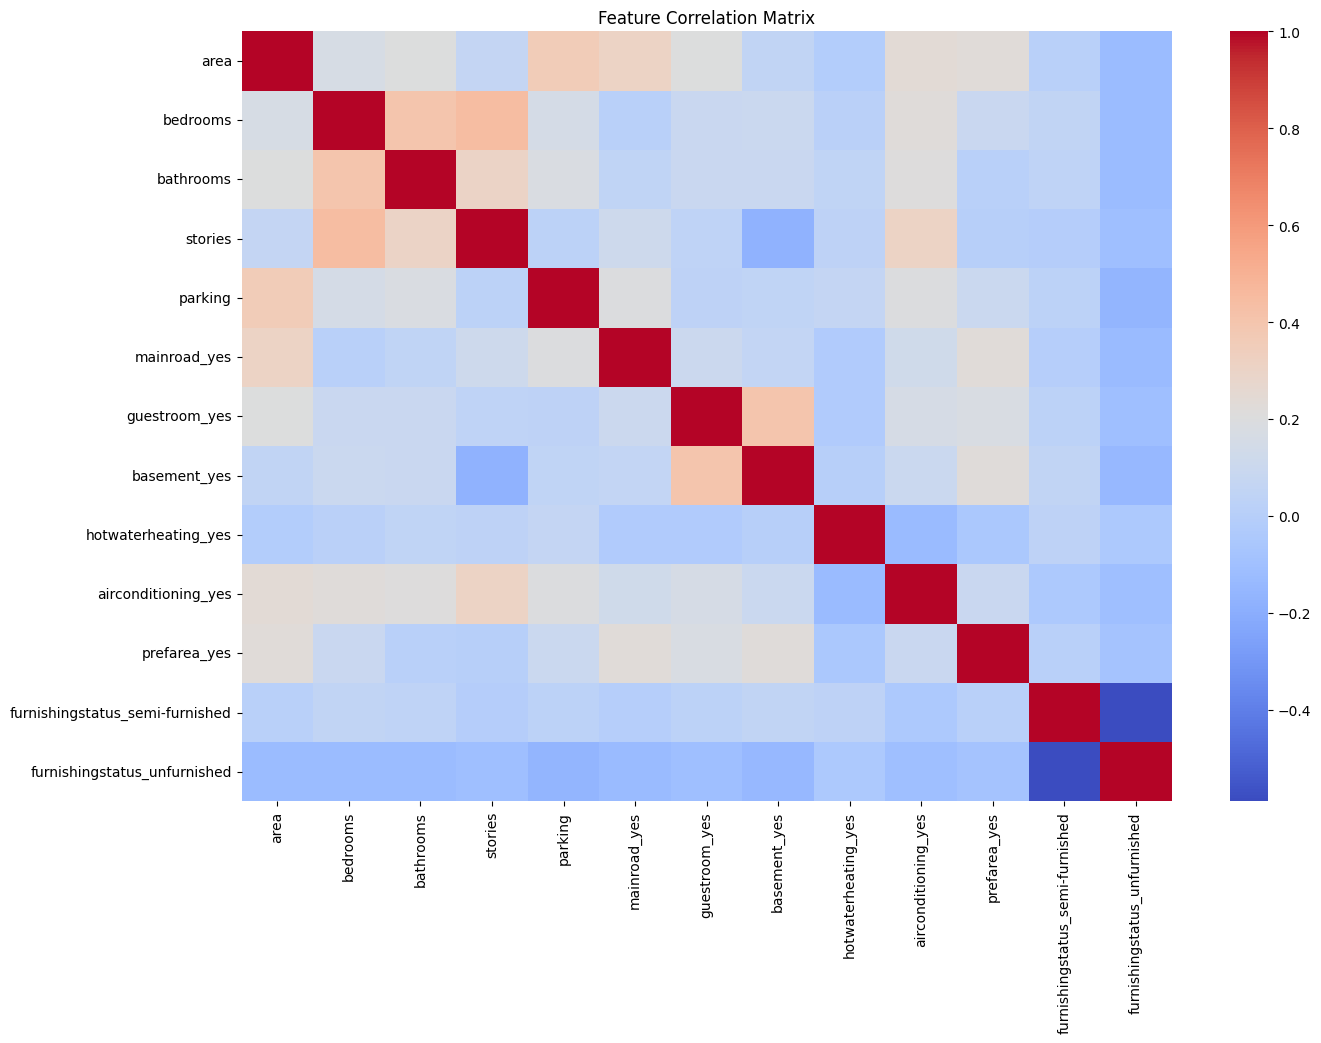

In [22]:
plt.figure(figsize=(15, 10))
corr_matrix = X_scaled.corr()

sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()


**2. Principal Component Analysis (PCA)**

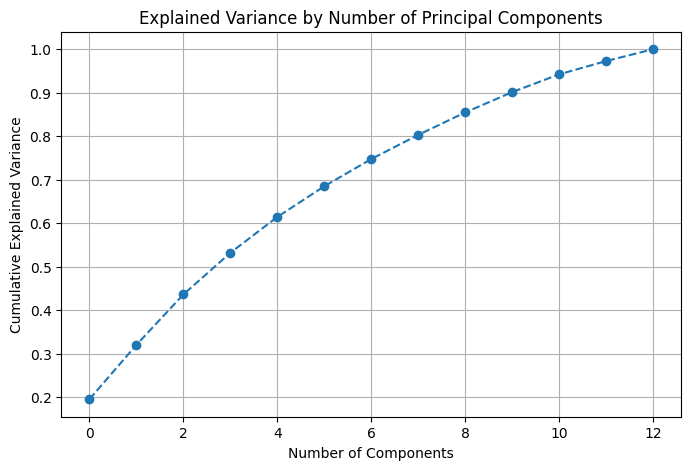

Number of components selected (95% variance threshold): 12
Shape of transformed PCA data: (436, 12)


In [32]:
pca = PCA()
pca.fit(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.grid(True)
plt.show()



explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components selected (95% variance threshold): {n_components}")

# Transform data using selected components
pca_final = PCA(n_components=n_components)
X_train_pca = pca_final.fit_transform(X_scaled)

print(f"Shape of transformed PCA data: {X_train_pca.shape}")



**Optional 1**

In [33]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

print("\nVIF values for features:")
display(vif_data.sort_values(by="VIF", ascending=False))


VIF values for features:


,Feature,VIF
12,furnishingstatus_unfurnished,1.695279
11,furnishingstatus_semi-furnished,1.587195
3,stories,1.547346
1,bedrooms,1.468454
7,basement_yes,1.378603
0,area,1.366038
2,bathrooms,1.285334
6,guestroom_yes,1.272195
9,airconditioning_yes,1.265309
4,parking,1.231844


**Optional 2**

In [34]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=10)  # You can adjust number as needed
rfe.fit(X_scaled, y_train)

selected_features = X_train.columns[rfe.support_]
print("\nTop 10 selected features using RFE:")
print(selected_features.tolist())


Top 10 selected features using RFE:
['area', 'bathrooms', 'stories', 'parking', 'mainroad_yes', 'basement_yes', 'hotwaterheating_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_unfurnished']


# **Part 6: Model Training**

**Helper function to evaluate model performance**

In [49]:
# Helper function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2 = r2_score(y_test, y_test_pred)

    print(f"\n📊 {model_name} Performance:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")

    # Scatter plot: predicted vs actual
    plt.figure(figsize=(5, 4))
    plt.scatter(y_test, y_test_pred, alpha=0.6)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"{model_name}: Actual vs Predicted")
    plt.grid(True)
    plt.show()

    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2}



**1. Multiple Linear Regression**


📊 Multiple Linear Regression Performance:
MAE:  880919.5116
RMSE: 1134300.2555
R²:   0.6815


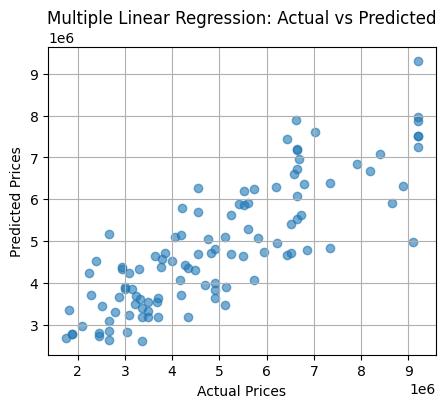

In [50]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

results = []
results.append(evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test, "Multiple Linear Regression"))


**2. Ridge Regression**


📊 Ridge Regression Performance:
MAE:  880661.5574
RMSE: 1134317.1759
R²:   0.6815


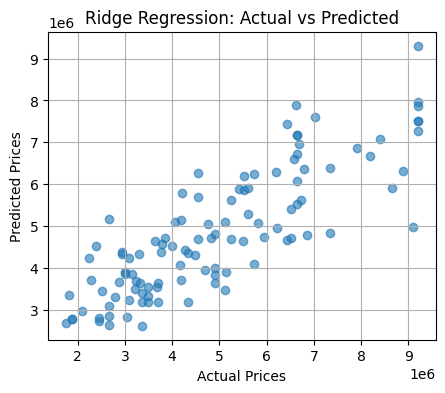

In [51]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

results.append(evaluate_model(ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge Regression"))


**3. Lasso Regression**


📊 Lasso Regression Performance:
MAE:  880919.5117
RMSE: 1134300.2559
R²:   0.6815


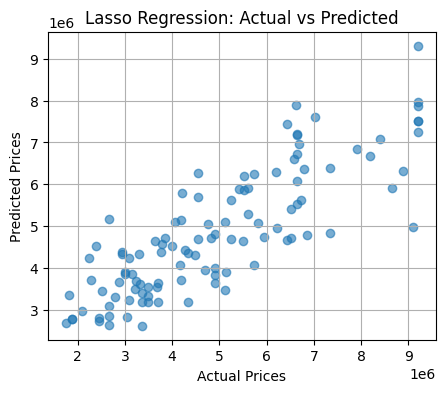

In [52]:
lasso_model = Lasso(alpha=0.001, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)

results.append(evaluate_model(lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, "Lasso Regression"))



**4. Polynomial Regression**


📊 Polynomial Regression (Degree 2) Performance:
MAE:  935666.8547
RMSE: 1210550.8809
R²:   0.6373


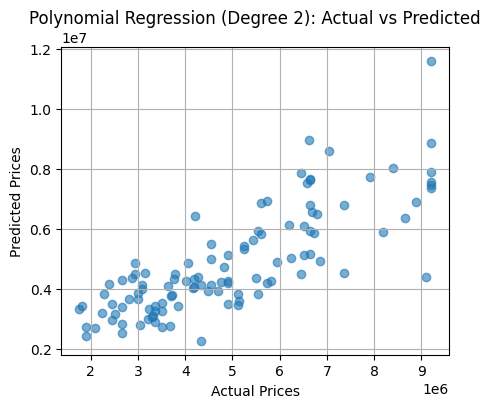

In [53]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

results.append(evaluate_model(poly_model, X_train_poly, X_test_poly, y_train, y_test, "Polynomial Regression (Degree 2)"))


**5. Multi-Layer Perceptron (MLP)**

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



📊 MLP Regressor Performance:
MAE:  4840170.2668
RMSE: 5216729.5204
R²:   -5.7364


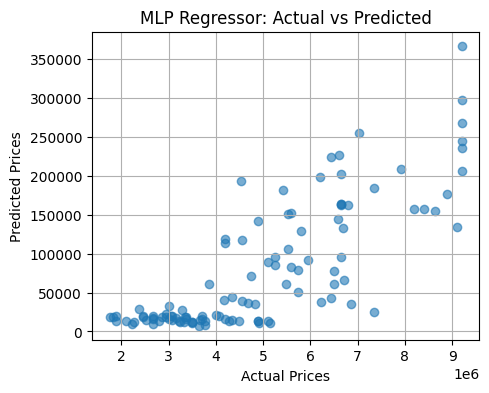

In [54]:
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32),
                         activation='relu',
                         solver='adam',
                         learning_rate='adaptive',
                         max_iter=500,
                         random_state=42)

mlp_model.fit(X_train_scaled, y_train)

results.append(evaluate_model(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test, "MLP Regressor"))



**(Optional) 6. Elastic-Net Regression**


📊 Elastic-Net Regression Performance:
MAE:  880862.9935
RMSE: 1134303.3942
R²:   0.6815


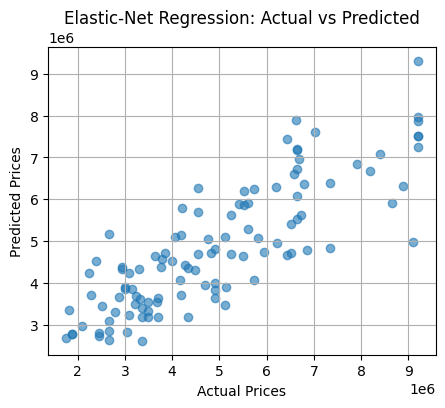

In [55]:
elastic_model = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
elastic_model.fit(X_train_scaled, y_train)

results.append(evaluate_model(elastic_model, X_train_scaled, X_test_scaled, y_train, y_test, "Elastic-Net Regression"))


**7. Compare All Models**

,Model,MAE,RMSE,R2
0,Multiple Linear Regression,8.809195e+05,1.134300e+06,0.681517
2,Lasso Regression,8.809195e+05,1.134300e+06,0.681517
5,Elastic-Net Regression,8.808630e+05,1.134303e+06,0.681515
1,Ridge Regression,8.806616e+05,1.134317e+06,0.681507
3,Polynomial Regression (Degree 2),9.356669e+05,1.210551e+06,0.637259
4,MLP Regressor,4.840170e+06,5.216730e+06,-5.736385


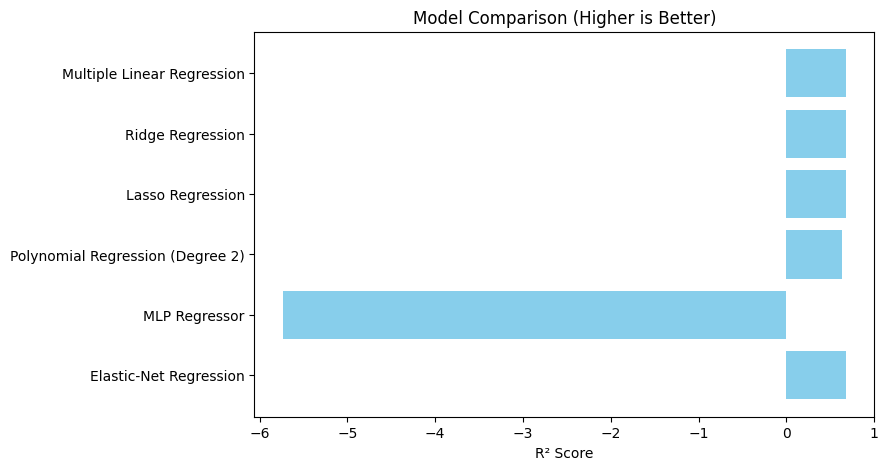

In [56]:
results_df = pd.DataFrame(results)
display(results_df.sort_values(by="R2", ascending=False))

plt.figure(figsize=(8, 5))
plt.barh(results_df["Model"], results_df["R2"], color='skyblue')
plt.xlabel("R² Score")
plt.title("Model Comparison (Higher is Better)")
plt.gca().invert_yaxis()
plt.show()

# **Part 7: USING MLP FOR FEATURE SELECTION (FEATURE EXTRACTION) & CLASSIFICATION**

**0. Create 4-class labels from 'price' using quartiles**


In [59]:
if 'price' not in df_encoded.columns:
    raise ValueError("Expected 'price' as target column in df_encoded. Adjust code to your target.")

# Use the original (non-capped) price for binning if available (or use the preprocessed y)
# We will bin y (which is the same target used in Section 4)
y_all = y  # Series from previous section
# Create 4 classes using quartiles
bins = np.quantile(y_all, [0.0, 0.25, 0.5, 0.75, 1.0])
y_class = pd.cut(y_all, bins=bins, labels=[0,1,2,3], include_lowest=True).astype(int)

# Ensure y_train_class and y_test_class align with X_train/X_test indexes
# We need to reconstruct train/test split indices — if original split used random_state=42 earlier, do same split:
from sklearn.model_selection import train_test_split
X_full = X  # from Section 4
y_class_full = y_class

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_full, y_class_full, test_size=0.2, random_state=42
)

# But we also have scaled arrays X_train_scaled, X_test_scaled (numpy arrays).
# Ensure scaling & ordering align: we will re-create scaled arrays using the scaler from Section 4
# (assuming 'scaler' exists)
X_train_scaled_arr = X_train_scaled  # numpy array from Section 4
X_test_scaled_arr = X_test_scaled

# Convert class vectors to categorical for Keras
y_train_cat = to_categorical(y_train_cls, num_classes=4)
y_test_cat = to_categorical(y_test_cls, num_classes=4)


**1. Build and train an MLP classifier (Keras)**

In [60]:
input_dim = X_train_scaled_arr.shape[1]

# You decide architecture — here's a reasonable choice:
# 3 hidden layers: 128 -> 64 -> 32 with dropout and ReLU, final Dense(4, softmax)
def build_mlp(input_dim, hidden_layers=(128,64,32), dropout_rate=0.2, lr=1e-3):
    inputs = Input(shape=(input_dim,))
    x = inputs
    for units in hidden_layers:
        x = Dense(units, activation='relu')(x)
        if dropout_rate and dropout_rate>0:
            x = Dropout(dropout_rate)(x)
    # last hidden layer before final output
    last_hidden = Dense(32, activation='relu', name='last_hidden')(x)
    outputs = Dense(4, activation='softmax', name='output')(last_hidden)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build model
mlp_cls = build_mlp(input_dim=input_dim, hidden_layers=(128,64), dropout_rate=0.2, lr=1e-3)
mlp_cls.summary()

# Train with early stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
history = mlp_cls.fit(
    X_train_scaled_arr, y_train_cat,
    validation_split=0.15,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_hidden (Dense)             │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,260 (47.89 KB)

 Trainable params: 12,260 (47.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
12/12 - 4s - 322ms/step - accuracy: 0.2973 - loss: 1.3823 - val_accuracy: 0.3485 - val_loss: 1.3048
Epoch 2/200
12/12 - 0s - 37ms/step - accuracy: 0.3784 - loss: 1.2796 - val_accuracy: 0.4848 - val_loss: 1.2277
Epoch 3/200
12/12 - 0s - 40ms/step - accuracy: 0.4595 - loss: 1.1809 - val_accuracy: 0.5455 - val_loss: 1.1553
Epoch 4/200
12/12 - 0s - 28ms/step - accuracy: 0.5189 - loss: 1.0982 - val_accuracy: 0.5758 - val_loss: 1.0748
Epoch 5/200
12/12 - 0s - 37ms/step - accuracy: 0.5432 - loss: 1.0308 - val_accuracy: 0.5455 - val_loss: 1.0186
Epoch 6/200
12/12 - 0s - 24ms/step - accuracy: 0.6135 - loss: 0.9576 - val_accuracy: 0.5152 - val_loss: 0.9766
Epoch 7/200
12/12 - 0s - 18ms/step - accuracy: 0.6189 - loss: 0.9190 - val_accuracy: 0.5152 - val_loss: 0.9346
Epoch 8/200
12/12 - 0s - 31ms/step - accuracy: 0.6243 - loss: 0.8759 - val_accuracy: 0.4848 - val_loss: 0.9251
Epoch 9/200
12/12 - 0s - 17ms/step - accuracy: 0.6324 - loss: 0.8363 - val_accuracy: 0.5000 - val_loss: 0.9380


**2. Extract features from the last hidden layer**

In [61]:
feature_extractor = Model(inputs=mlp_cls.input, outputs=mlp_cls.get_layer('last_hidden').output)

# Extract for train and test
train_features = feature_extractor.predict(X_train_scaled_arr)
test_features  = feature_extractor.predict(X_test_scaled_arr)

print("Extracted feature shapes:", train_features.shape, test_features.shape)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Extracted feature shapes: (436, 32) (109, 32)


**3. Evaluate MLP classifier on test set**

In [62]:
y_test_pred_proba = mlp_cls.predict(X_test_scaled_arr)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

acc_mlp = accuracy_score(y_test_cls, y_test_pred)
print("\nMLP Classifier Accuracy on test set:", acc_mlp)
print("\nClassification Report (MLP):")
print(classification_report(y_test_cls, y_test_pred))

# Confusion matrix
cm_mlp = confusion_matrix(y_test_cls, y_test_pred)
print("Confusion Matrix (MLP):\n", cm_mlp)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

MLP Classifier Accuracy on test set: 0.6330275229357798

Classification Report (MLP):
              precision    recall  f1-score   support

           0       0.71      0.78      0.75        32
           1       0.37      0.53      0.43        19
           2       0.53      0.38      0.44        24
           3       0.83      0.74      0.78        34

    accuracy                           0.63       109
   macro avg       0.61      0.60      0.60       109
weighted avg       0.65      0.63      0.64       109

Confusion Matrix (MLP):
 [[25  7  0  0]
 [ 5 10  3  1]
 [ 4  7  9  4]
 [ 1  3  5 25]]


**4. Convert regression models' predictions to 4 classes and compare**

In [66]:
def preds_to_classes(y_numeric_preds, bins):
    y_clipped = np.clip(y_numeric_preds, bins[0], bins[-1])
    y_binned = pd.cut(y_clipped, bins=bins, labels=[0,1,2,3], include_lowest=True)
    return y_binned.astype(int)

# Evaluate all regression models as classification
regress_to_class_results = []
for name, model in regression_models.items():
    if model is None:
        continue
    if name == "Polynomial":
        y_reg_pred = model.predict(X_test_poly)
    else:
        y_reg_pred = model.predict(X_test_scaled_arr)

    y_reg_class = preds_to_classes(y_reg_pred, bins)
    acc = accuracy_score(y_test_cls, y_reg_class)
    regress_to_class_results.append({"Model": name, "Accuracy": acc})
    print(f"{name} -> classification accuracy after binning: {acc:.4f}")


LinearRegression -> classification accuracy after binning: 0.4954
Ridge -> classification accuracy after binning: 0.4954
Lasso -> classification accuracy after binning: 0.4954
Polynomial -> classification accuracy after binning: 0.5505
MLPRegressor -> classification accuracy after binning: 0.2936
ElasticNet -> classification accuracy after binning: 0.4954


**5. Compare MLP classifier accuracy vs regression->class accuracies**

In [68]:
comp_df = pd.DataFrame(regress_to_class_results)

# Append MLP_Classifier result using pd.concat
mlp_row = pd.DataFrame([{"Model": "MLP_Classifier", "Accuracy": acc_mlp}])
comp_df = pd.concat([comp_df, mlp_row], ignore_index=True)

display(comp_df.sort_values(by='Accuracy', ascending=False))


,Model,Accuracy
6,MLP_Classifier,0.633028
3,Polynomial,0.550459
0,LinearRegression,0.495413
2,Lasso,0.495413
1,Ridge,0.495413
5,ElasticNet,0.495413
4,MLPRegressor,0.293578


**6. Visualize extracted features (PCA to 2D)**

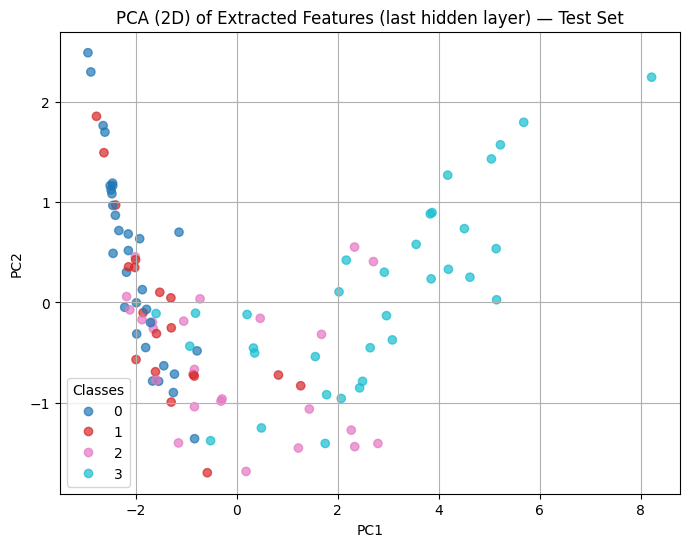

In [69]:

pca_vis = PCA(n_components=2)
test_feat_2d = pca_vis.fit_transform(test_features)

plt.figure(figsize=(8,6))
scatter = plt.scatter(test_feat_2d[:,0], test_feat_2d[:,1], c=y_test_cls, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA (2D) of Extracted Features (last hidden layer) — Test Set")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)